# 0. Business Objective

Detail information of dataset can can be found here 

https://docs.google.com/spreadsheets/d/1iT1JNOBwU4l616_rnJpo0iny7blZvNBs/edit#gid=1666154857


We'd like to make prediction of credit risk application and whether to be approved or not from dataset that consist loan information 

# 1. Instal and Import Necessary Library

In [ ]:
!pip install scikit-plot
!pip install -U matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 3.9 MB/s 
     |████████████████████████████████| 959 kB 42.8 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from itertools import product

%matplotlib inline


# 2. Import Dataset

In [ ]:
data = pd.read_csv('https://rakamin-lms.s3.ap-southeast-1.amazonaws.com/vix-assets/idx-partners/loan_data_2007_2014.csv', sep=',', decimal='.', low_memory=False)
data.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [ ]:
data.shape

(466285, 75)

In [ ]:
data.drop(columns='Unnamed: 0',inplace=True)

# 3. Make Target Variable

In [ ]:
# create copy to make Target variable 
df = data.copy()

In [ ]:
# check column 'loan_status' as Target variable 
df['loan_status'].value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [ ]:
# Charged Off, Default, and Late Credit as Bad Credits
df['target'] = np.where((df['loan_status'] =='Charged Off') | 
                         (df['loan_status'] =='Does not meet the credit policy. Status:Fully Paid') |
                         (df['loan_status'] =='Late (31-120 days)') | 
                         (df['loan_status'] =='Late (16-30 days)') | 
                         (df['loan_status'] =='Does not meet the credit policy. Status:Charged Off'),1,0)

In [ ]:
#Drop original coloumn 'loan_status' variable, since it has been extracted to Target
df.drop('loan_status', axis=1, inplace=True);

In [ ]:
df_cr = df.groupby('target').agg({'id':'count'}).reset_index()
df_cr.columns = ['target','total']
df_cr['%'] = round(df_cr['total']*100/sum(df_cr['total']),3)
df_cr

,target,total,%
0,0,412943,88.56
1,1,53342,11.44


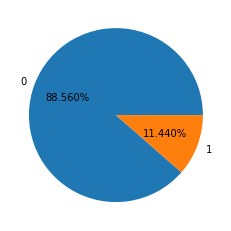

In [ ]:
plt.pie(df_cr['total'],labels=df_cr['target'], autopct='%.3f%%')
plt.show()

In [ ]:
df.groupby('target').agg({'funded_amnt':'sum','total_pymnt':'sum'}).reset_index()

,target,funded_amnt,total_pymnt
0,0,5898598725,5.000213e+09
1,1,765453725,3.810357e+08


Following information above, can be seen that the target variable has been categorized by

*   Good Credit or 0: In Grace Period, Fully Paid, Current, Default
*   Bad Credit or 1 : Charged off, Late (31-120 days), Late (16-30 days), Does not meet the credit policy. Status:Charged Off, Does not meet the credit policy. Status:Fully Paid

Hence, pie chart shows bad credit rate = **11.192%**. Machine learning model would be set to decrease default rate until <5%

# 4. Cleaning and Handling Data

In [ ]:
#Drop All-Null Column
df1 = df.copy()
for column in df1.columns:
  length = len(df1[column])
  number_of_missing = df1[column].isna().sum()
  if length == number_of_missing:
    df1.drop(column, axis = 1, inplace = True)

In [ ]:
#Split Variable into categoric and numeric
numeric_vars = []
categorical_vars = []

for i in df1.columns:
  if df1[i].dtype == 'object':
    categorical_vars.append(i)
  else:
    numeric_vars.append(i)

print('Count of Numerical Vars: ',len(numeric_vars))
print('Numerical Vars: ',numeric_vars)
print()
print('Count of Categorical Vars: ',len(categorical_vars))
print('Categorical Vars = ',categorical_vars)

Count of Numerical Vars:  36
Numerical Vars:  ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'target']

Count of Categorical Vars:  21
Categorical Vars =  ['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'application_type']


## Handling numerical features

In [ ]:
df1[numeric_vars].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,466285.0,1.307973e+07,1.089371e+07,54734.00,3.639987e+06,1.010790e+07,2.073121e+07,3.809811e+07
member_id,466285.0,1.459766e+07,1.168237e+07,70473.00,4.379705e+06,1.194108e+07,2.300154e+07,4.086083e+07
loan_amnt,466285.0,1.431728e+04,8.286509e+03,500.00,8.000000e+03,1.200000e+04,2.000000e+04,3.500000e+04
funded_amnt,466285.0,1.429180e+04,8.274371e+03,500.00,8.000000e+03,1.200000e+04,2.000000e+04,3.500000e+04
funded_amnt_inv,466285.0,1.422233e+04,8.297638e+03,0.00,8.000000e+03,1.200000e+04,1.995000e+04,3.500000e+04
int_rate,466285.0,1.382924e+01,4.357587e+00,5.42,1.099000e+01,1.366000e+01,1.649000e+01,2.606000e+01
installment,466285.0,4.320612e+02,2.434855e+02,15.67,2.566900e+02,3.798900e+02,5.665800e+02,1.409990e+03
annual_inc,466281.0,7.327738e+04,5.496357e+04,1896.00,4.500000e+04,6.300000e+04,8.896000e+04,7.500000e+06
dti,466285.0,1.721876e+01,7.851121e+00,0.00,1.136000e+01,1.687000e+01,2.278000e+01,3.999000e+01
delinq_2yrs,466256.0,2.846784e-01,7.973651e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,2.900000e+01


**Insight**

Drop `policy_code` columns, due to has 0 standard deviation and will not useful to build a model, together with `id` and `member_id`

In [ ]:
#drop policy_code
dropping = ['policy_code', 'id', 'member_id']
for i in dropping:
  df1.drop(i, axis = 1, inplace = True)
  numeric_vars.remove(i)

In [ ]:
df1.shape

(466285, 54)

In [ ]:
# Check Missing Data Percentage (Before)
for column in numeric_vars:
  length = len(df1[column])
  number_of_missing = df1[column].isna().sum()
  precentage_of_missing = number_of_missing*100/length
  print('Percentage of Missing Value from Column ' + str(column) + ' is ' + str(format(precentage_of_missing, ".2f") + '%'))

Percentage of Missing Value from Column loan_amnt is 0.00%
Percentage of Missing Value from Column funded_amnt is 0.00%
Percentage of Missing Value from Column funded_amnt_inv is 0.00%
Percentage of Missing Value from Column int_rate is 0.00%
Percentage of Missing Value from Column installment is 0.00%
Percentage of Missing Value from Column annual_inc is 0.00%
Percentage of Missing Value from Column dti is 0.00%
Percentage of Missing Value from Column delinq_2yrs is 0.01%
Percentage of Missing Value from Column inq_last_6mths is 0.01%
Percentage of Missing Value from Column mths_since_last_delinq is 53.69%
Percentage of Missing Value from Column mths_since_last_record is 86.57%
Percentage of Missing Value from Column open_acc is 0.01%
Percentage of Missing Value from Column pub_rec is 0.01%
Percentage of Missing Value from Column revol_bal is 0.00%
Percentage of Missing Value from Column revol_util is 0.07%
Percentage of Missing Value from Column total_acc is 0.01%
Percentage of Missi

In [ ]:
#Drop Column with Percentage of Missing values > 40%, If missing value < 40% replace it with median
for column in numeric_vars:
  portion_missing = df1[column].isna().sum()/len(df1[column])
  if portion_missing > 0.4:
    df1.drop(column, axis=1, inplace = True)
    numeric_vars.remove(column)
  else:
    df1[column].fillna(df1[column].median(), inplace = True)

In [ ]:
# Check Missing Data Percentage (After)
for column in numeric_vars:
  length = len(df1[column])
  number_of_missing = df1[column].isna().sum()
  precentage_of_missing = number_of_missing*100/length
  print('Precentage of Missing Value from Column ' + str(column) + ' is ' + str(format(precentage_of_missing, ".2f") + '%'))

Precentage of Missing Value from Column loan_amnt is 0.00%
Precentage of Missing Value from Column funded_amnt is 0.00%
Precentage of Missing Value from Column funded_amnt_inv is 0.00%
Precentage of Missing Value from Column int_rate is 0.00%
Precentage of Missing Value from Column installment is 0.00%
Precentage of Missing Value from Column annual_inc is 0.00%
Precentage of Missing Value from Column dti is 0.00%
Precentage of Missing Value from Column delinq_2yrs is 0.00%
Precentage of Missing Value from Column inq_last_6mths is 0.00%
Precentage of Missing Value from Column mths_since_last_record is 86.57%
Precentage of Missing Value from Column open_acc is 0.00%
Precentage of Missing Value from Column pub_rec is 0.00%
Precentage of Missing Value from Column revol_bal is 0.00%
Precentage of Missing Value from Column revol_util is 0.00%
Precentage of Missing Value from Column total_acc is 0.00%
Precentage of Missing Value from Column out_prncp is 0.00%
Precentage of Missing Value from 

In [ ]:
#drop manually mths_since_last_record 
df1.drop('mths_since_last_record', axis=1, inplace = True)
numeric_vars.remove('mths_since_last_record')

## Handling categorical features

In [ ]:
df1[categorical_vars].describe().transpose()

,count,unique,top,freq
term,466285,2,36 months,337953
grade,466285,7,B,136929
sub_grade,466285,35,B3,31686
emp_title,438697,205475,Teacher,5399
emp_length,445277,11,10+ years,150049
home_ownership,466285,6,MORTGAGE,235875
verification_status,466285,3,Verified,168055
issue_d,466285,91,Oct-14,38782
pymnt_plan,466285,2,n,466276
url,466285,466285,https://www.lendingclub.com/browse/loanDetail....,1


**Insight**

1. `emp_title`,`url`,`desc`,`title`,`zip_code`,`addr_state`,`sub_grade` dropped due to extreme unique values 
2. Feature `application_type` will not be used since have one value and no information is found
3. convert `issue_d`, `last_pymnt_d`, `next_pymnt_d`, `earliest_cr_line`, `last_credit_pull_d` to datetime

In [ ]:
#Drop Columns
columns_to_drop = ['emp_title', 'url', 'desc', 'title', 'zip_code', 'addr_state', 'sub_grade', 'application_type']
df1.drop(columns_to_drop, axis = 1, inplace = True)
for i in columns_to_drop:
  categorical_vars.remove(i)

In [ ]:
#Convert to Datetime and Remove it from categorical 
convert_to_date = ['issue_d', 'last_pymnt_d', 'next_pymnt_d', 'earliest_cr_line', 'last_credit_pull_d']
date_vars = convert_to_date
for i in convert_to_date:
  df1[i] = pd.to_datetime(df1[i], format = '%b-%y')
for i in date_vars:
  categorical_vars.remove(i)

In [ ]:
#Check Again dataset
df1[categorical_vars].describe().transpose()

,count,unique,top,freq
term,466285,2,36 months,337953
grade,466285,7,B,136929
emp_length,445277,11,10+ years,150049
home_ownership,466285,6,MORTGAGE,235875
verification_status,466285,3,Verified,168055
pymnt_plan,466285,2,n,466276
purpose,466285,14,debt_consolidation,274195
initial_list_status,466285,2,f,303005


In [ ]:
#Data Checking
df1[date_vars].describe().transpose()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


,count,unique,top,freq,first,last
issue_d,466285,91,2014-10-01,38782,2007-06-01,2014-12-01
last_pymnt_d,465909,98,2016-01-01,179620,2007-12-01,2016-01-01
next_pymnt_d,239071,100,2016-02-01,208393,2007-12-01,2016-03-01
earliest_cr_line,466256,664,2000-10-01,3674,1969-01-01,2068-12-01
last_credit_pull_d,466243,103,2016-01-01,327699,2007-05-01,2016-01-01


In [ ]:
#Split each datetime variable into year and month

df1['m_issue_d'] = df1['issue_d'].dt.month
df1['m_last_pymnt_d'] = df1['last_pymnt_d'].dt.month
df1['m_next_pymnt_d'] = df1['next_pymnt_d'].dt.month
df1['y_next_pymnt_d'] = df1['next_pymnt_d'].dt.year
df1['m_earliest_cr_line'] = df1['earliest_cr_line'].dt.month
df1['y_earliest_cr_line'] = df1['earliest_cr_line'].dt.year
df1['m_last_credit_pull_d'] = df1['last_credit_pull_d'].dt.month

#Drop old datetime variable (and we will not use the year variable)
df1.drop(date_vars, axis = 1, inplace = True)
date_vars = ['m_issue_d', 'm_last_pymnt_d', 'm_next_pymnt_d', 'm_earliest_cr_line', 'm_last_credit_pull_d']


In [ ]:
#Drop Rows with NaN
df2 = df1.dropna(axis=0)

# 5. Explatory Data Analysis

## Univariat analysis

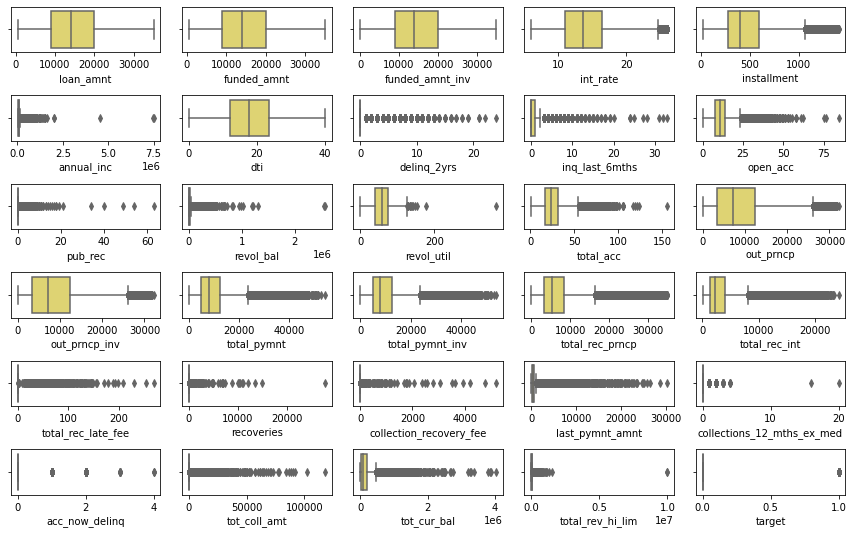

In [ ]:
#Numerical features
plt.figure(figsize=(12,12))
for i in range(0, len(numeric_vars)):
    plt.subplot(10, 5, i+1)
    sns.boxplot(x=df2[numeric_vars[i]], color='#F0E161')
    plt.xlabel(numeric_vars[i])
    plt.tight_layout()

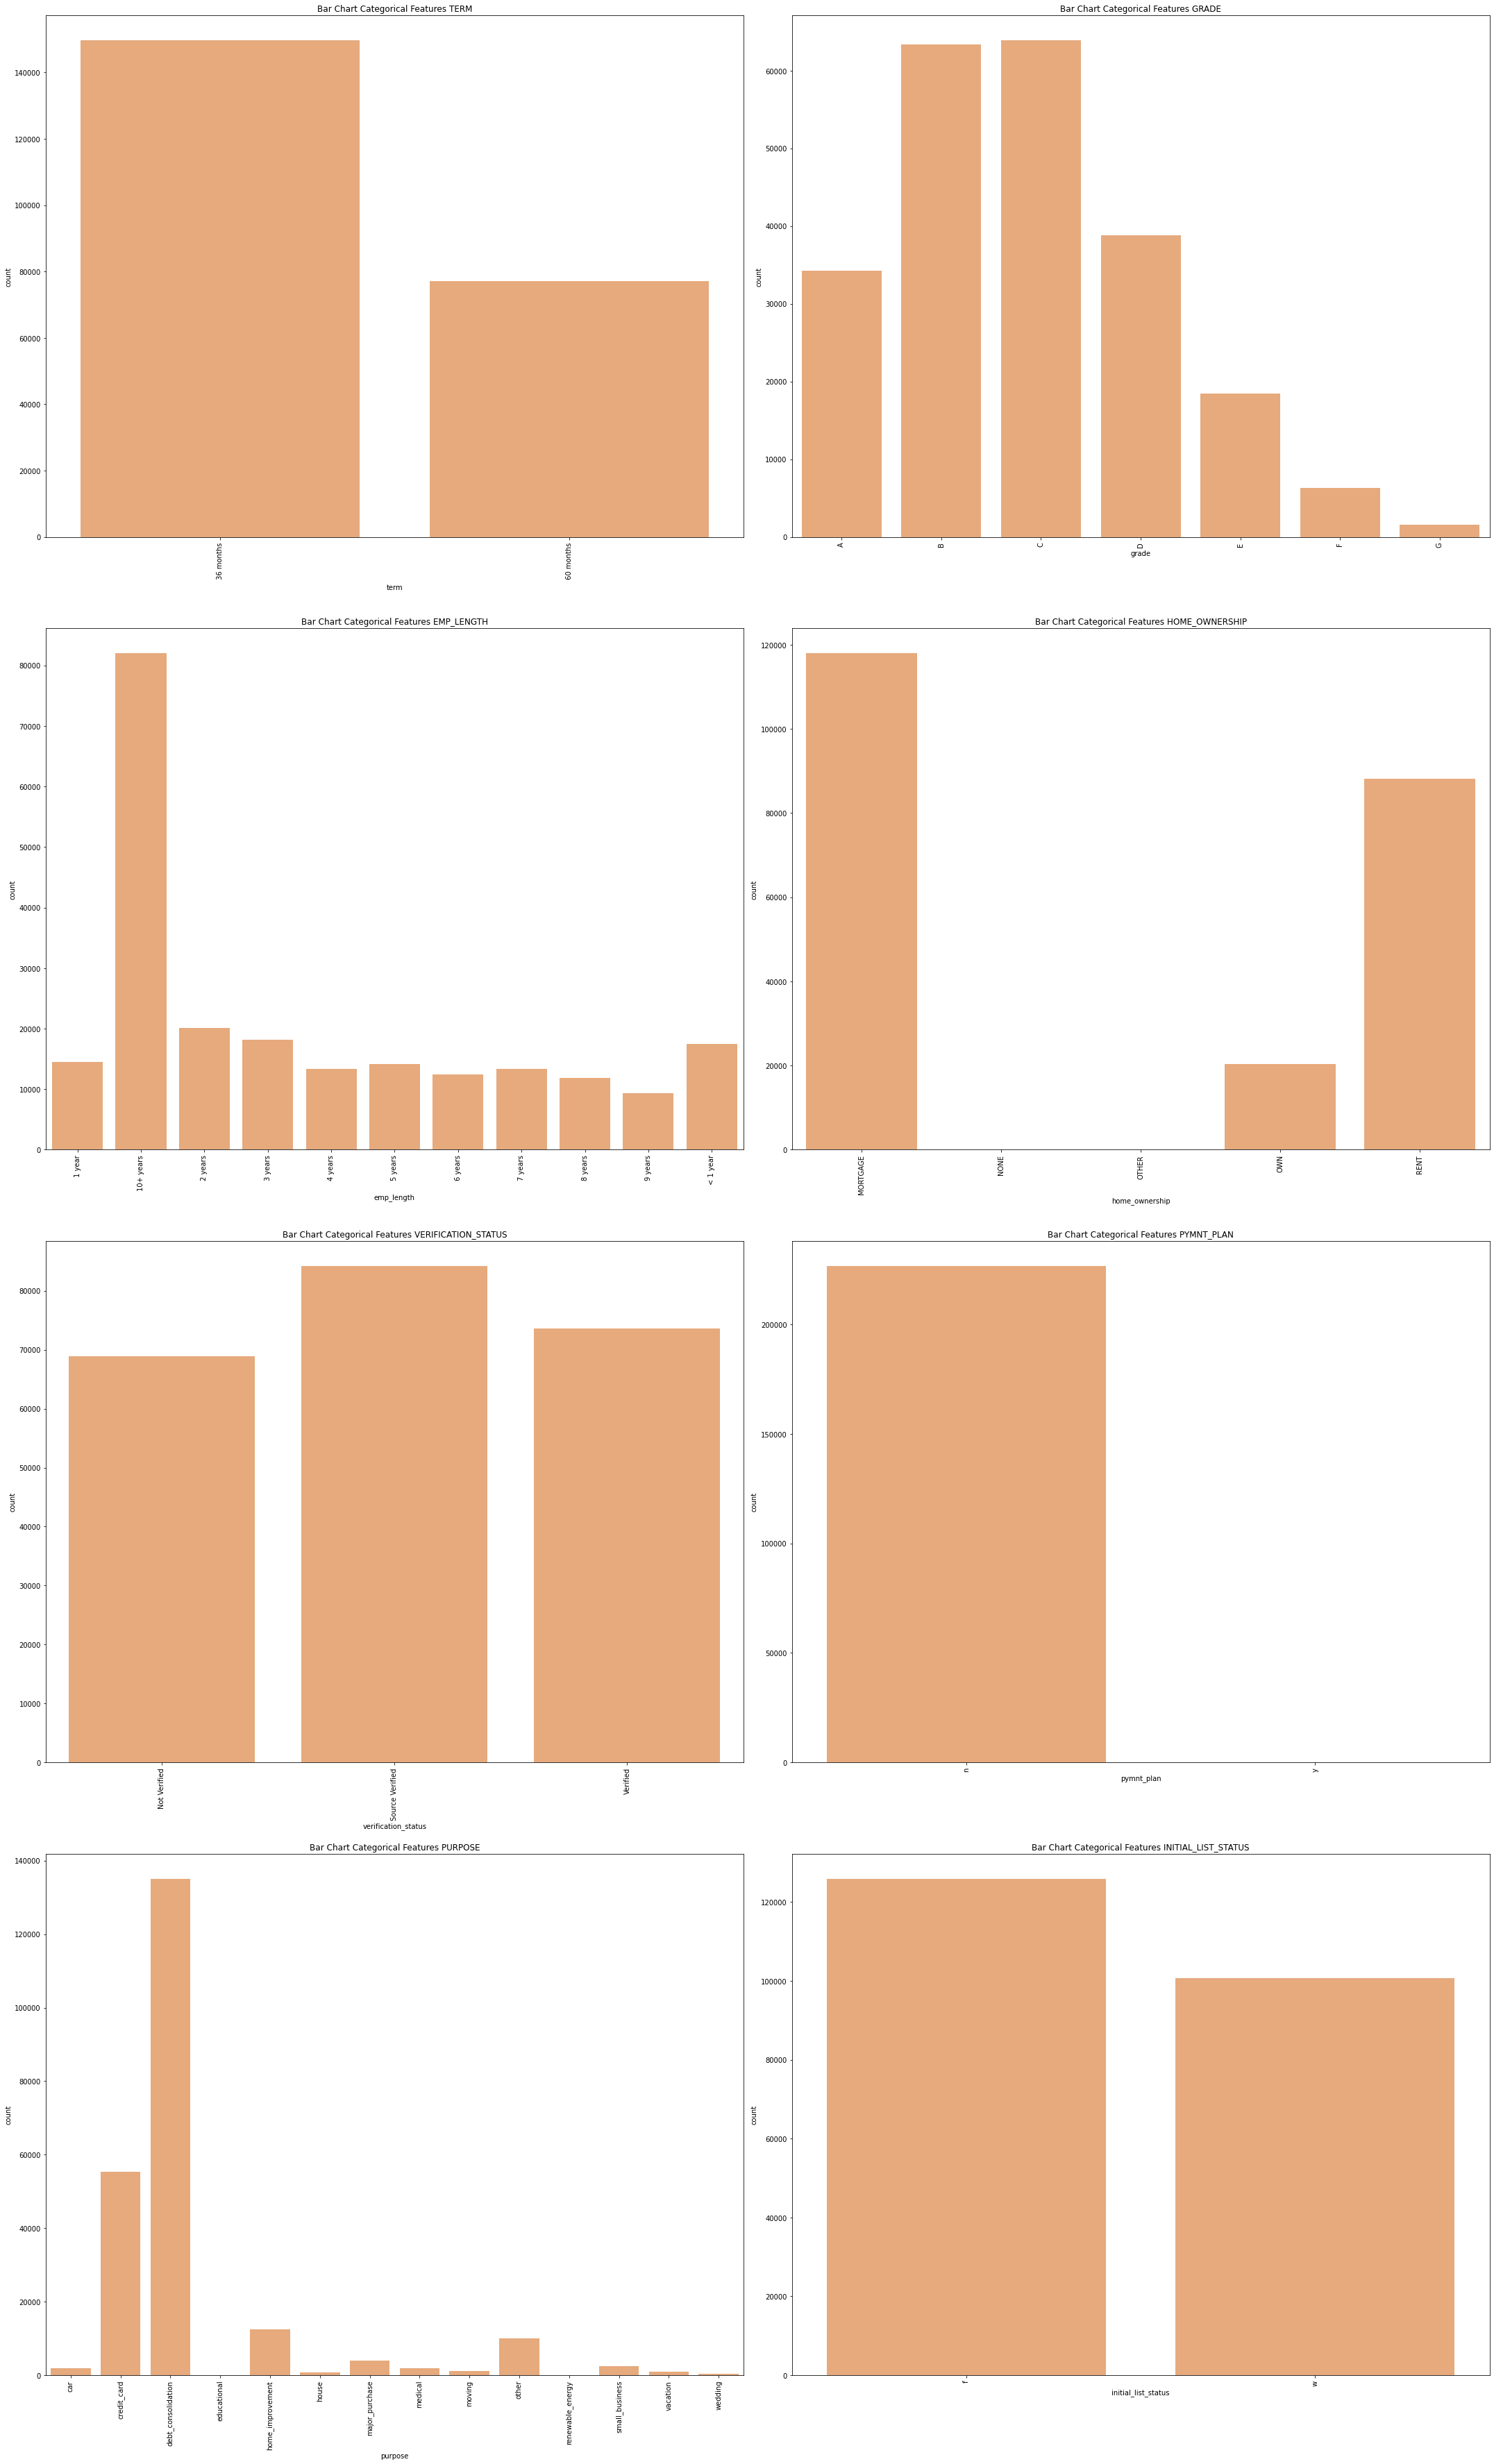

In [ ]:
#Categorical Features
plt.figure(figsize=(30,60))
for i in range(0, len(categorical_vars)):
    plt.subplot(5, 2, i+1)
    plt.title('Bar Chart Categorical Features ' + str(categorical_vars[i]).upper())
    sns.countplot(x=df2[categorical_vars[i]].sort_values(), color='#F7A76C')
    plt.xlabel(categorical_vars[i])
    plt.xticks(rotation=90)
    plt.tight_layout()

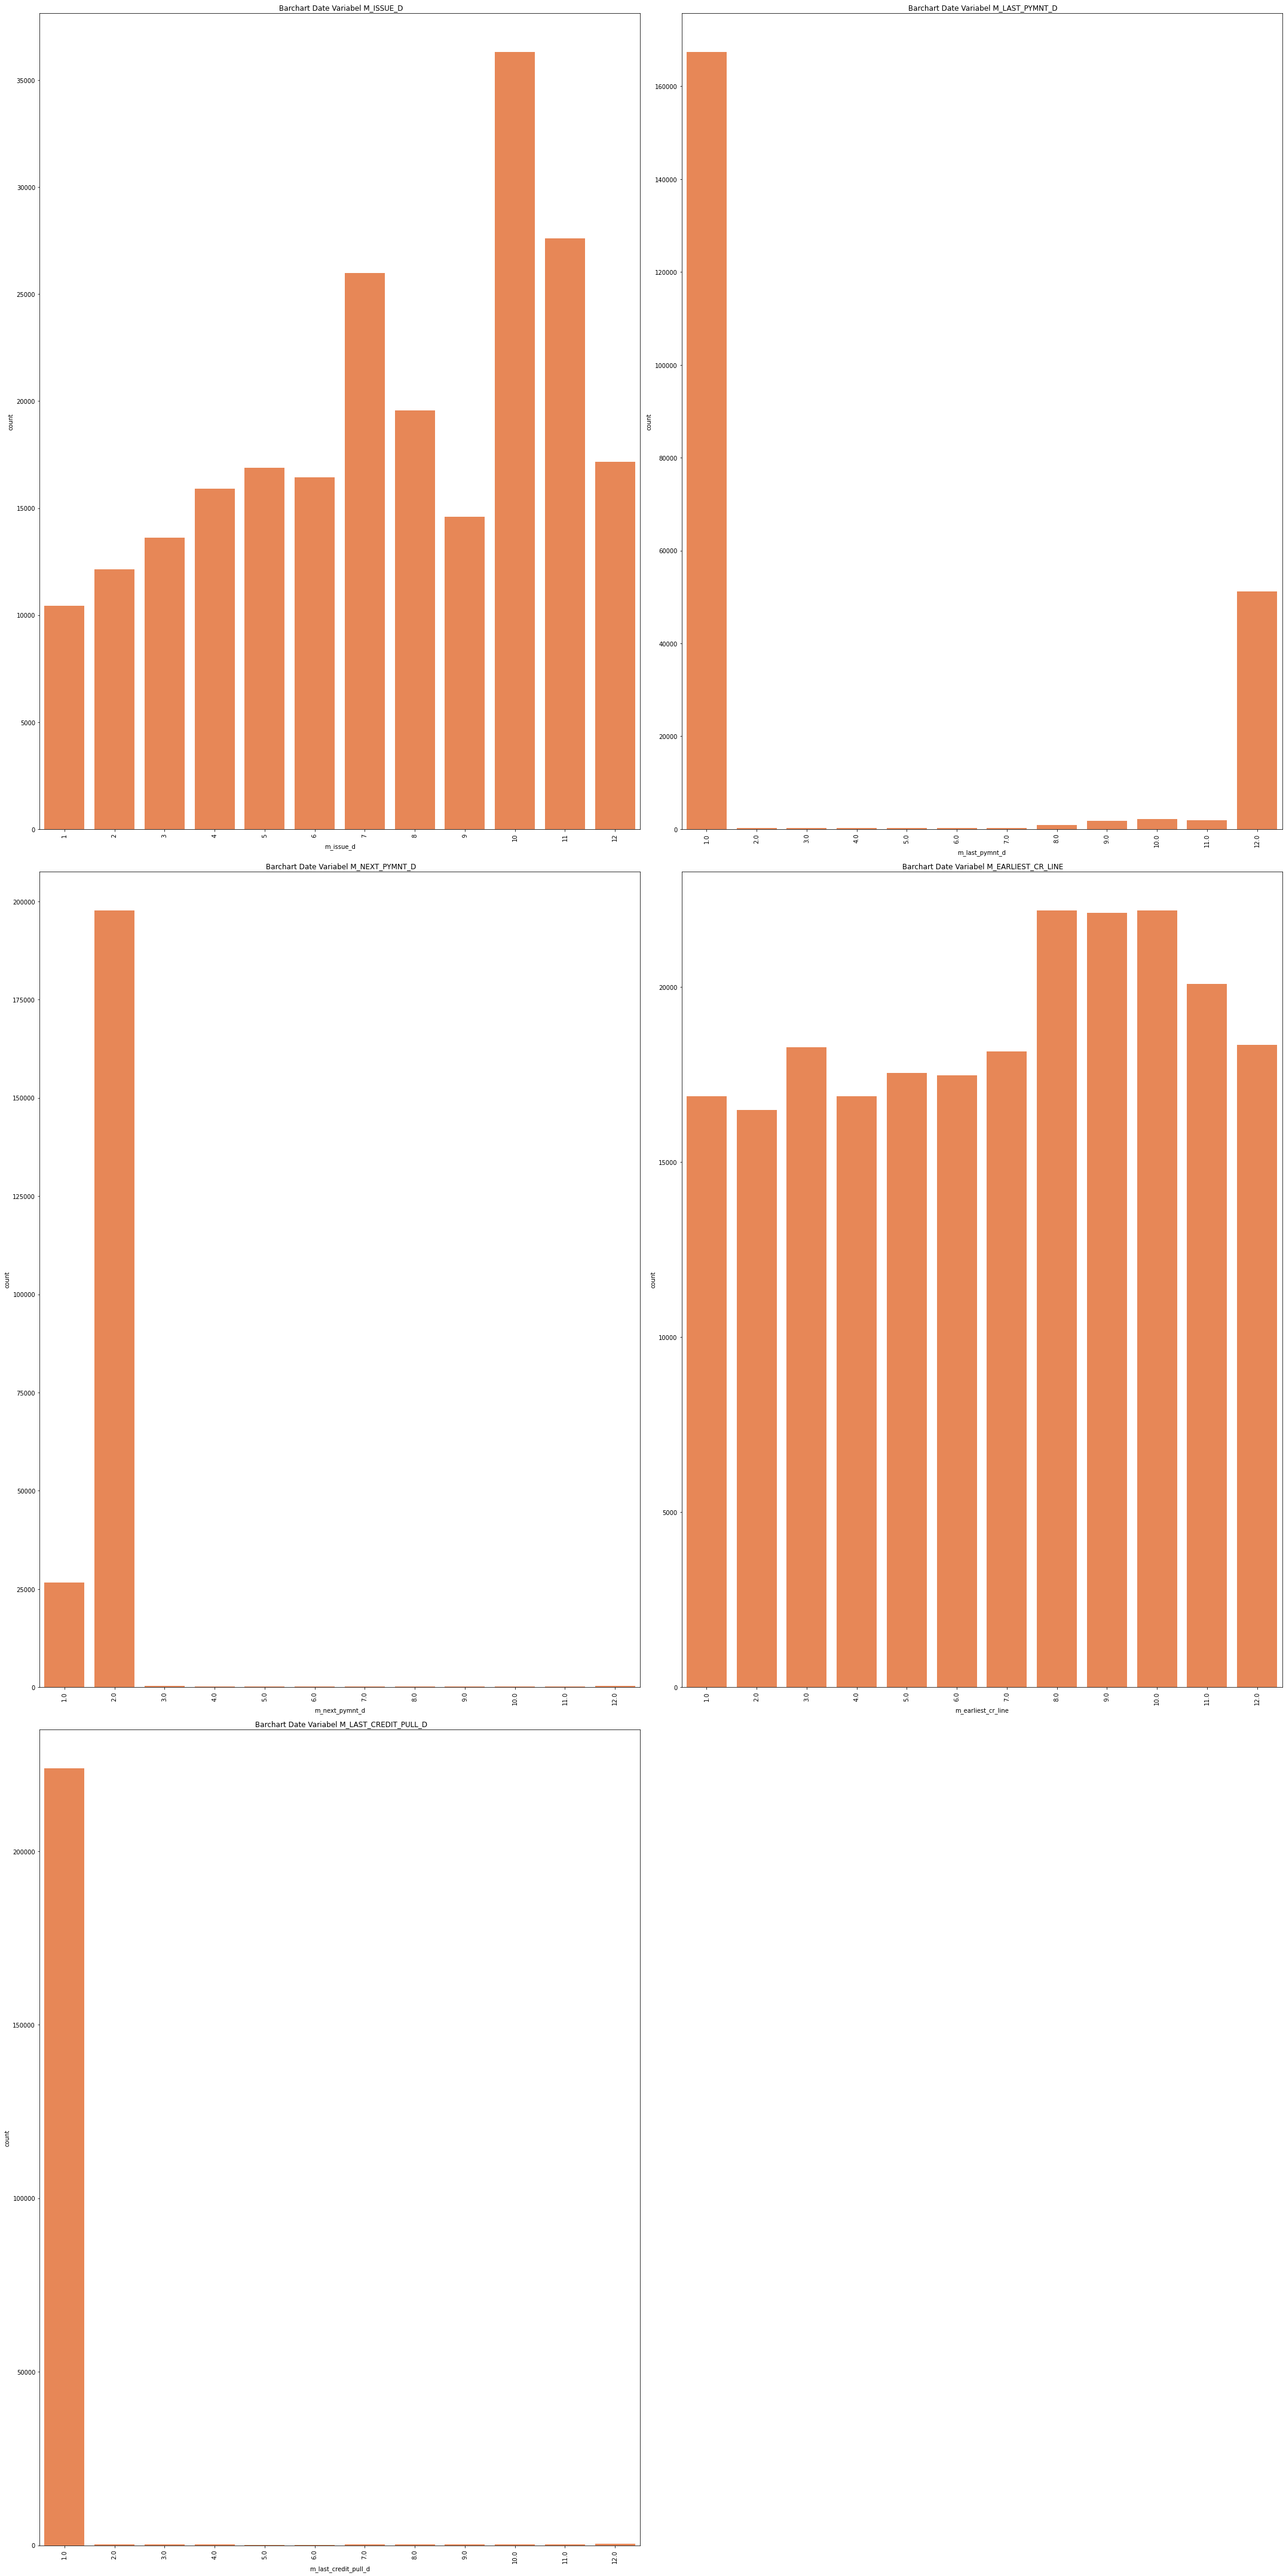

In [ ]:
#Date Variable
plt.figure(figsize=(30,60))
for i in range(0, len(date_vars)):
    plt.subplot(3, 2, i+1)
    plt.title(' Barchart Date Variabel ' + str(date_vars[i]).upper())
    sns.countplot(x=df2[date_vars[i]].sort_values(), color='#FF7F3F')
    plt.xlabel(date_vars[i])
    plt.xticks(rotation=90)
    plt.tight_layout()

## Bivariat Analysis

In [ ]:
#Function Definition
def credit_graphic(index, columns):
  dfp = df2.pivot_table(index=index, columns=columns, aggfunc='size')
  
  dfp_prt = dfp.copy()
  dfp.iloc[0,0]
  for i in range(0, dfp.shape[0]):
    for j in range(0, dfp.shape[1]):
      dfp_prt.iloc[i,j] = dfp.iloc[i,j]/sum(dfp.iloc[i,:])

  labels = np.array(dfp_prt.index)
  bad_credit_score = np.array(dfp_prt.iloc[:,0])
  good_credit_score = np.array(dfp_prt.iloc[:,1])

  precentage = lambda x: np.round(x, 2)*100
  bad_credit = precentage(bad_credit_score)
  good_credit = precentage(good_credit_score)

  x = np.arange(len(labels))
  width = 0.35
  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, bad_credit, width, label='Bad Credit')
  rects2 = ax.bar(x + width/2, good_credit, width, label='Good Credit')
  
  ax.set_ylabel('Precentage')
  ax.set_xlabel(str(index).capitalize())
  ax.set_title('Portions of Credit_Approver by ' + str(index).capitalize() + ' and Credit')
  ax.set_xticks(x, labels)
  ax.legend()
  
  ax.bar_label(rects1, padding=3)
  ax.bar_label(rects2, padding=3)
  fig.tight_layout()
  fig.set_size_inches(18, 9)
  
  plt.show()

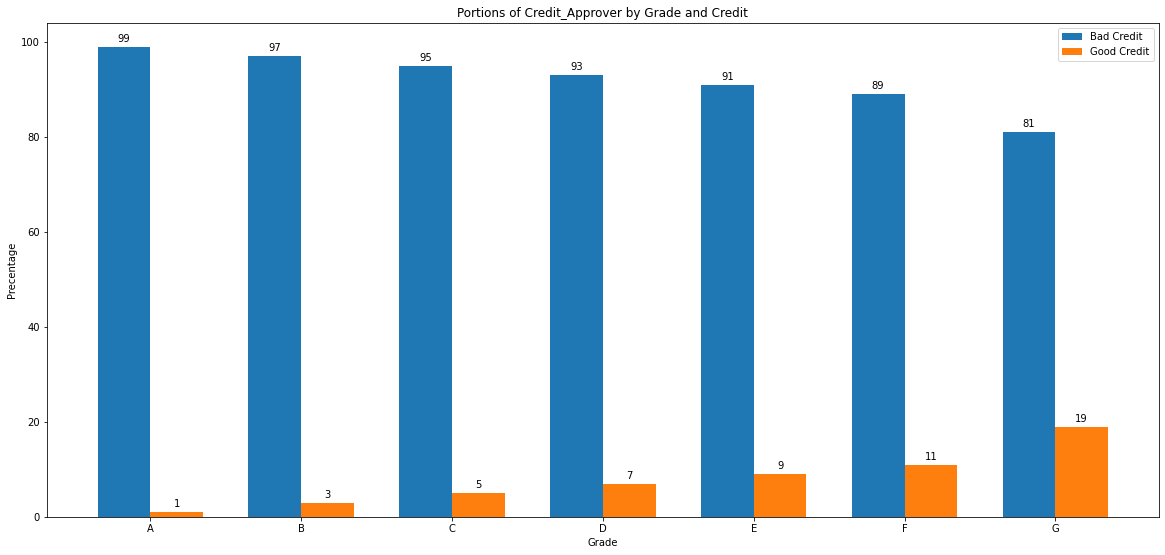

In [ ]:
#Grade vs Target
credit_graphic(index='grade', columns='target')

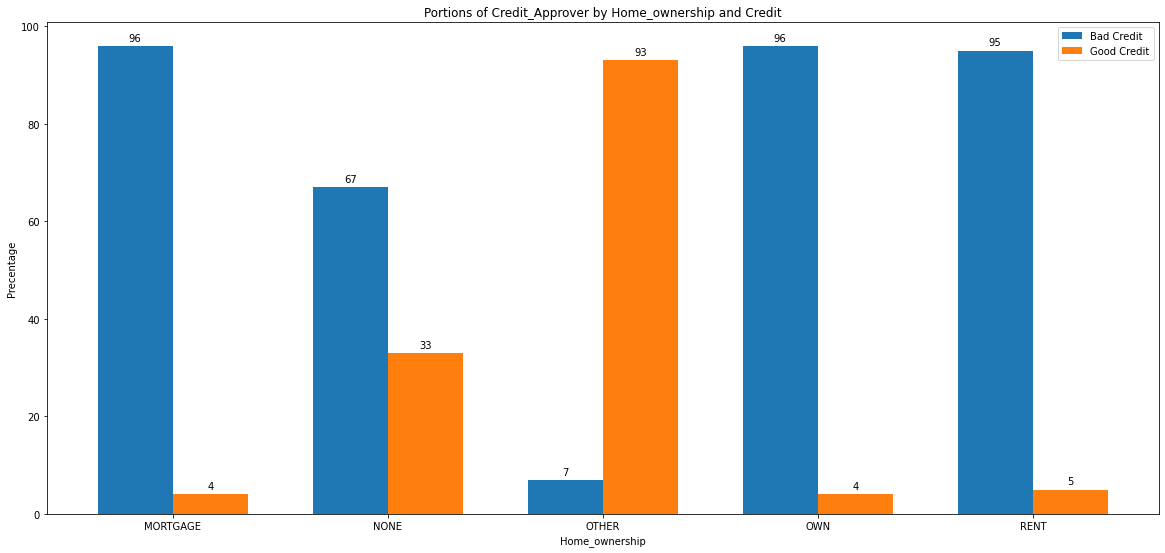

In [ ]:
#home_ownership vs Target
credit_graphic(index='home_ownership', columns='target')

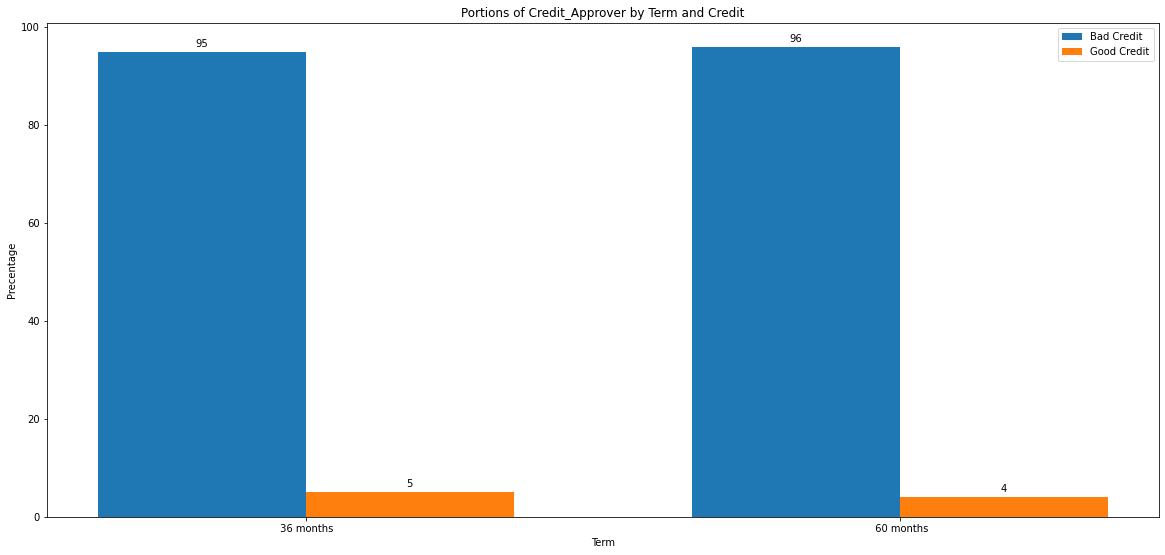

In [ ]:
#Term vs Target
credit_graphic(index='term', columns='target')

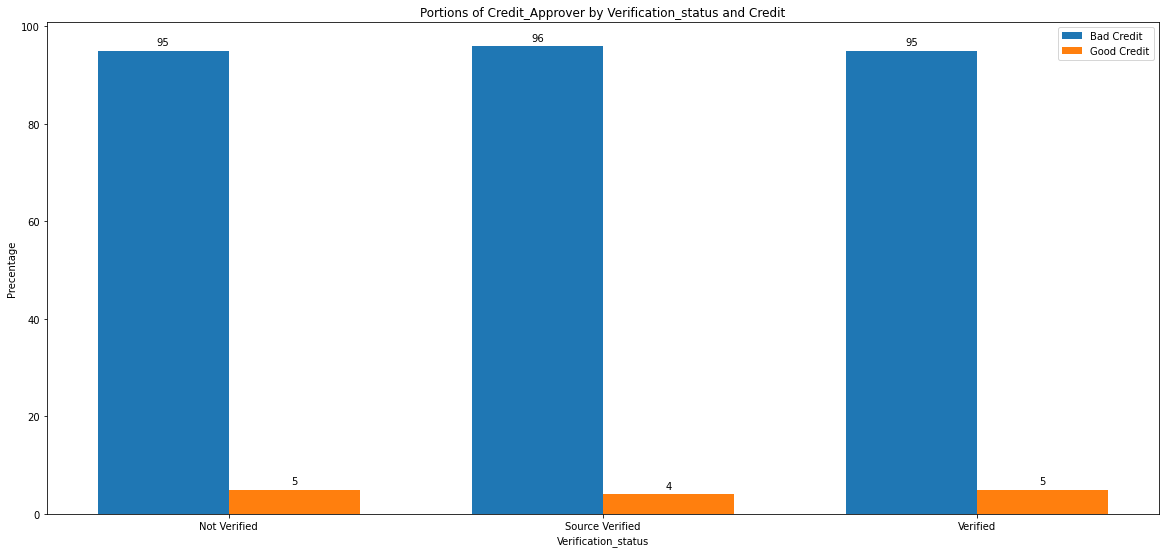

In [ ]:
#Verification Status vs Target
credit_graphic(index='verification_status', columns='target')

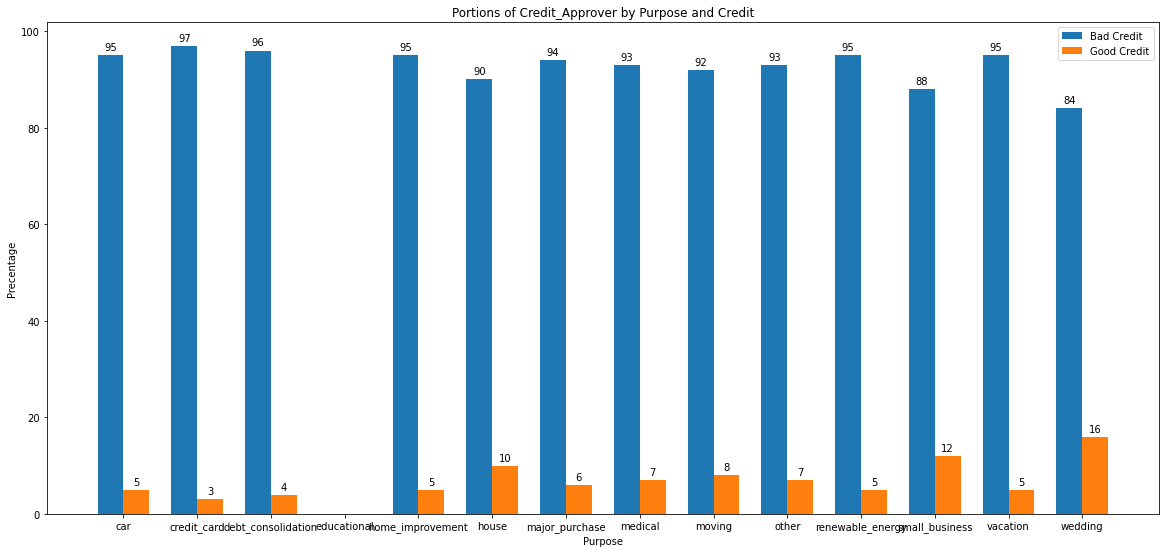

In [ ]:
#Purpose vs Target
credit_graphic(index='purpose', columns='target')

# 6. Feature Engineering

## Label Encoding

In [ ]:
df_encode = df2.copy()

In [ ]:
df_encode.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,226677.0,15299.482634,8437.234888,500.00,9000.00,14000.00,20000.00,35000.00
funded_amnt,226677.0,15292.525267,8433.722090,500.00,9000.00,14000.00,20000.00,35000.00
funded_amnt_inv,226677.0,15253.714040,8455.207471,0.00,9000.00,14000.00,20000.00,35000.00
int_rate,226677.0,13.877034,4.337721,6.00,10.99,13.66,16.49,26.06
installment,226677.0,450.937024,242.862073,15.67,274.29,398.52,589.52,1409.99
annual_inc,226677.0,75774.724671,55292.642509,1896.00,46800.00,65000.00,90000.00,7500000.00
dti,226677.0,17.969009,7.905391,0.00,12.03,17.61,23.63,39.99
delinq_2yrs,226677.0,0.327439,0.864512,0.00,0.00,0.00,0.00,24.00
inq_last_6mths,226677.0,0.747045,1.108372,0.00,0.00,0.00,1.00,33.00
open_acc,226677.0,11.596695,5.153009,0.00,8.00,11.00,14.00,84.00


In [ ]:
df_encode.home_ownership.replace({'NONE':'OTHER','ANY':'OTHER','OWN':'OTHER'},inplace=True)
df_encode.home_ownership.unique()

array(['RENT', 'OTHER', 'MORTGAGE'], dtype=object)

In [ ]:
df_encode.grade.replace({'G':0,'F':1,'E':2,'D':3,'C':4,'B':5,'A':6},inplace=True)
df_encode.emp_length.replace({'< 1 year':0, '1 year':1, '2 years':2,
                                           '3 years':3, '4 years':4, '5 years':5,
                                           '6 years':6, '7 years':7, '8 years':8, 
                                           '9 years':9, '10+ years':10},inplace=True)
df_encode.initial_list_status.replace({'w':0,'f':1},inplace=True)
df_encode.home_ownership.replace({'MORTGAGE':0, 'OTHER':1, 'RENT':2},inplace=True)
df_encode.verification_status.replace({'Not Verified':0, 'Source Verified':1, 'Verified':2},inplace=True)


In [ ]:
#Label encoding for categorical data
le_purpose = preprocessing.LabelEncoder()
le_purpose.fit(df_encode['purpose'])
print(le_purpose.classes_)
df_encode['purpose'] = le_purpose.transform(df_encode['purpose'])

['car' 'credit_card' 'debt_consolidation' 'educational' 'home_improvement'
 'house' 'major_purchase' 'medical' 'moving' 'other' 'renewable_energy'
 'small_business' 'vacation' 'wedding']


In [ ]:
df_encode['term'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df_encode['term'] = df_encode['term'].astype(int)
set(df_encode["term"])

{36, 60}

In [ ]:
def year(x):
  if int( x['y_earliest_cr_line']) >= 2000:
    result = '00s'
  else:
    if int( x['y_earliest_cr_line']) >= 1990:
      result = '90s'
    elif int( x['y_earliest_cr_line']) >= 1980:
      result = '80s'
    elif int( x['y_earliest_cr_line']) >= 1970:
      result = '70s'
    elif int( x['y_earliest_cr_line']) >= 1960:
      result = '60s'
    else:
      result = '50s'
  return result

In [ ]:
df_encode['earliest_cr_line_year_seg'] = df_encode.apply(lambda x : year(x),axis=1)
df_encode[['y_earliest_cr_line','earliest_cr_line_year_seg']].sample(10)

,y_earliest_cr_line,earliest_cr_line_year_seg
156033,2000.0,00s
269343,2003.0,00s
169617,1987.0,80s
82465,2006.0,00s
456173,2000.0,00s
456787,1999.0,90s
248775,2005.0,00s
100269,1998.0,90s
364152,2002.0,00s
251683,2004.0,00s


In [ ]:
df_encode.earliest_cr_line_year_seg.replace({'50s':0, '60s':1, '70s':2,
                                           '80s':3, '90s':4, '00s':5},inplace=True)

In [ ]:
df_encode.drop(columns='y_earliest_cr_line',inplace=True)

In [ ]:
df_encode.shape

(226677, 45)

In [ ]:
df_encode['term'].nunique()

2

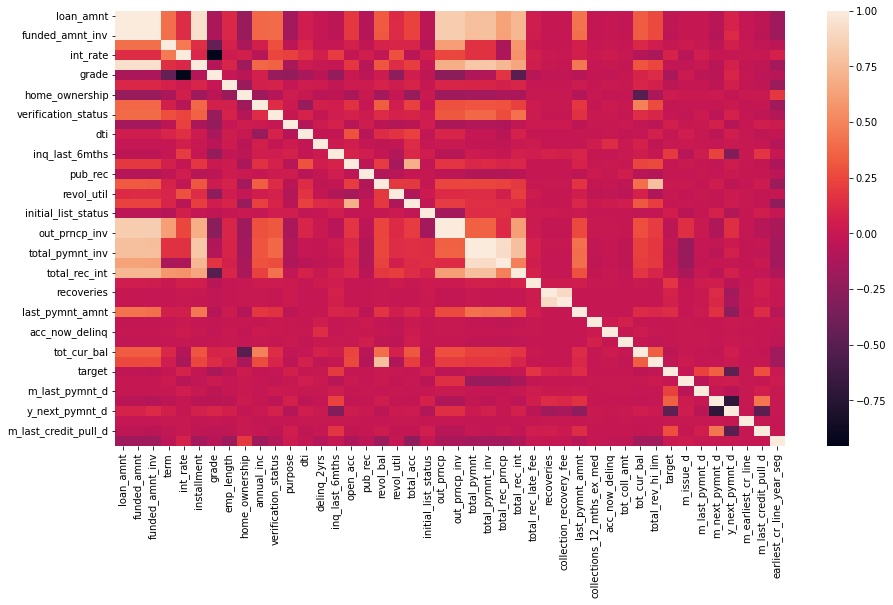

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(df_encode.corr(),fmt='2.f')
plt.show()

## Check Multicollinearity and Select The Features

In [ ]:
sm_df = df_encode.corr(method='spearman')
sm_df.style.applymap(lambda x: "background-color: red" if x>0.7 else "background-color: white")

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target,m_issue_d,m_last_pymnt_d,m_next_pymnt_d,y_next_pymnt_d,m_earliest_cr_line,m_last_credit_pull_d,earliest_cr_line_year_seg
loan_amnt,1.000000,0.999710,0.996914,0.440707,0.108373,0.958500,-0.096299,0.116249,-0.215427,0.502049,0.380171,-0.102857,0.052582,-0.002285,-0.040533,0.204200,-0.129078,0.522054,0.121267,0.245053,-0.052418,0.821161,0.821016,0.828698,0.829396,0.685264,0.827677,-0.008463,-0.034239,-0.033648,0.937520,-0.020684,-0.001581,-0.077131,0.355763,0.467302,-0.034022,-0.002541,-0.005708,-0.029836,0.085101,-0.013439,-0.056882,-0.186328
funded_amnt,0.999710,1.000000,0.997342,0.440267,0.108104,0.958939,-0.095731,0.116364,-0.215321,0.501954,0.380049,-0.103210,0.052806,-0.002250,-0.040945,0.204312,-0.128987,0.522029,0.121393,0.245001,-0.053076,0.822239,0.822098,0.828353,0.829238,0.684885,0.827447,-0.008656,-0.035778,-0.035168,0.937705,-0.020611,-0.001532,-0.076863,0.355830,0.467414,-0.035483,-0.002559,-0.006219,-0.030397,0.088018,-0.013516,-0.058686,-0.186044
funded_amnt_inv,0.996914,0.997342,1.000000,0.441381,0.107936,0.955549,-0.092498,0.118297,-0.214721,0.500071,0.381304,-0.105218,0.054510,-0.002091,-0.045318,0.204551,-0.127800,0.520142,0.121412,0.244927,-0.059825,0.827641,0.827544,0.822967,0.829461,0.679201,0.825136,-0.011858,-0.051767,-0.051257,0.933506,-0.020167,-0.001456,-0.074955,0.354993,0.466264,-0.052810,-0.000053,-0.010075,-0.038308,0.122862,-0.013515,-0.078995,-0.184459
term,0.440707,0.440267,0.441381,1.000000,0.459237,0.207524,-0.452095,0.076151,-0.125766,0.126544,0.279516,0.019322,0.092785,-0.008273,0.000891,0.070332,-0.042681,0.175920,0.096796,0.103751,-0.089381,0.615172,0.615058,0.192261,0.195410,-0.099315,0.621546,0.005427,-0.015551,-0.016717,0.201705,-0.010103,0.002803,-0.036188,0.166208,0.127676,-0.007481,0.021195,-0.000676,-0.018958,0.053076,0.001180,-0.037117,-0.063832
int_rate,0.108373,0.108104,0.107936,0.459237,1.000000,0.081536,-0.955619,0.024287,0.058424,-0.109914,0.242926,0.232725,0.148632,0.065983,0.210671,-0.021668,0.065154,-0.030918,0.285814,-0.067313,0.053929,0.205967,0.206024,0.121204,0.120991,-0.138861,0.539790,0.062112,0.013106,0.012441,0.081111,0.016021,0.029234,0.022319,-0.090304,-0.210771,0.084357,-0.079541,0.039930,-0.023499,-0.014530,0.001164,0.008189,0.067892
installment,0.958500,0.958939,0.955549,0.207524,0.081536,1.000000,-0.065548,0.103882,-0.183189,0.486026,0.343510,-0.095701,0.046344,0.008672,-0.018164,0.197580,-0.118241,0.504719,0.136026,0.223368,-0.019516,0.717221,0.717111,0.868017,0.867852,0.775711,0.768499,-0.003538,-0.031883,-0.031064,0.978413,-0.017055,0.001035,-0.068938,0.316676,0.438776,-0.024673,-0.021516,-0.001198,-0.030241,0.076964,-0.014946,-0.050963,-0.169527
grade,-0.096299,-0.095731,-0.092498,-0.452095,-0.955619,-0.065548,1.000000,-0.012997,-0.062922,0.110690,-0.205528,-0.238648,-0.147301,-0.068935,-0.212376,0.019626,-0.068275,0.040515,-0.265985,0.064729,-0.026331,-0.228547,-0.228620,-0.055199,-0.050298,0.201664,-0.481557,-0.063498,-0.043822,-0.042845,-0.069357,-0.020355,-0.029439,-0.026605,0.086618,0.204811,-0.116649,0.027328,-0.042594,0.000690,0.083702,-0.002176,-0.051867,-0.074418
emp_length,0.116249,0.116364,0.118297,0.076151,0.024287,0.103882,-0.012997,1.000000,-0.203530,0.126498,0.084225,0.010482,0.035681,0.035575,-0.014241,0.034722,0.034183,0.139539,0.037119,0.101159,-0.004154,0.102206,0.102204,0.097721,0.101033,0.072504,0.111076,-0.019524,-0.020239,-0.020339,0.096239,-0.005349,0.009742,0.004879,0.114350,0.118668,-0.039811,-0.010584,-0.009781,-0.020025,0.058331,-0.018723,-0.038361,-0.214717


In [ ]:
# Drop the coloumn who have multicollinearity
df3 = df_encode.drop(columns=['total_pymnt','pymnt_plan','collection_recovery_fee','recoveries','y_next_pymnt_d','funded_amnt','funded_amnt_inv','out_prncp_inv','total_pymnt_inv','total_rec_int','last_pymnt_amnt','installment','out_prncp','total_rec_prncp'])
df3.sample(15)

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,...,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target,m_issue_d,m_last_pymnt_d,m_next_pymnt_d,m_earliest_cr_line,m_last_credit_pull_d,earliest_cr_line_year_seg
292181,20000,36,14.99,4,1,2,56500.0,1,2,36.75,...,436.0,97636.0,17600.0,0,10,1.0,2.0,11.0,1.0,5
137271,5000,36,18.49,3,10,0,75000.0,2,2,13.84,...,0.0,279457.0,18700.0,0,5,12.0,2.0,1.0,1.0,4
436665,16000,36,11.99,5,4,0,68000.0,0,2,13.55,...,0.0,125306.0,81700.0,0,2,12.0,1.0,1.0,1.0,2
409671,16000,36,8.90,6,10,0,105000.0,2,2,17.33,...,0.0,170084.0,70900.0,0,4,1.0,2.0,3.0,1.0,3
139987,17000,36,8.90,6,0,0,101000.0,0,2,4.63,...,0.0,138711.0,49300.0,0,5,1.0,2.0,12.0,1.0,4
333328,8000,36,25.80,0,0,0,30000.0,2,8,7.76,...,0.0,144990.0,65100.0,0,8,1.0,2.0,11.0,1.0,3
435407,4125,36,14.16,4,0,2,20000.0,0,2,21.43,...,0.0,9577.0,24400.0,0,2,1.0,1.0,9.0,1.0,5
358757,24000,60,9.17,5,9,0,53000.0,1,1,26.27,...,0.0,146048.0,17400.0,0,7,1.0,2.0,10.0,1.0,4
144451,10625,36,14.09,5,9,2,32000.0,1,2,13.05,...,0.0,12375.0,21400.0,0,5,1.0,2.0,2.0,1.0,4
104758,35000,60,15.22,4,6,0,125000.0,2,1,12.04,...,70.0,684935.0,40200.0,0,8,1.0,2.0,7.0,1.0,4


# 7. Modelling Data

## Train Test Split

In [ ]:
#Assign X Var and Y Var
X_var = []
for i in df3.columns:
  X_var.append(i)
X_var.remove('target')

Y_var = ['target']

#Create Dataframe from Each Category
X = df3[X_var]
Y = df3[Y_var]

In [ ]:
def evaluationscore(Y_train, Y_test, Y_pred_train, Y_pred_test):
  print("Train Accuracy:",metrics.accuracy_score(Y_train, Y_pred_train))
  print("Test Accuracy:",metrics.accuracy_score(Y_test, Y_pred_test))
  print("Train F1-Score:",metrics.f1_score(Y_train, Y_pred_train))
  print("Test F1-Score:",metrics.f1_score(Y_test, Y_pred_test))
  F1_score = np.array([metrics.f1_score(Y_train, Y_pred_train), metrics.f1_score(Y_test, Y_pred_test)])
  return F1_score

def confusion_matrix(Y_pred, Y_act):
  confusion_matrix = metrics.confusion_matrix(Y_act, Y_pred)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
  cm_display.plot()
  plt.title('Confusion Matrix')
  plt.show()

In [ ]:
#Oversampling & Undersampling

rus = RandomUnderSampler(sampling_strategy=1)
X_Under, Y_Under = rus.fit_resample(X, Y)


ros = RandomOverSampler(sampling_strategy=1)
X_Over, Y_Over = ros.fit_resample(X, Y)

In [ ]:
#Train Test Split 80:20
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.20, random_state=1)

#Shape
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(181341, 30)
(45336, 30)
(181341, 1)
(45336, 1)


In [ ]:
#Train Test Split 80:20 Undersampling
X_train_u, X_test_u, Y_train_u, Y_test_u = train_test_split(X_Under,Y_Under,test_size=0.20, random_state=1)

#Shape
print(X_train_u.shape)
print(X_test_u.shape)
print(Y_train_u.shape)
print(Y_test_u.shape)

(16513, 30)
(4129, 30)
(16513, 1)
(4129, 1)


In [ ]:
#Train Test Split 80:20 Oversampling
X_train_o, X_test_o, Y_train_o, Y_test_o = train_test_split(X_Over,Y_Over,test_size=0.2, random_state=1)

#Shape
print(X_train_o.shape)
print(X_test_o.shape)
print(Y_train_o.shape)
print(Y_test_o.shape)

(346169, 30)
(86543, 30)
(346169, 1)
(86543, 1)


## Tuning Model

Train Accuracy: 1.0
Test Accuracy: 0.9745235574377977
Train F1-Score: 1.0
Test F1-Score: 0.7277869432005656



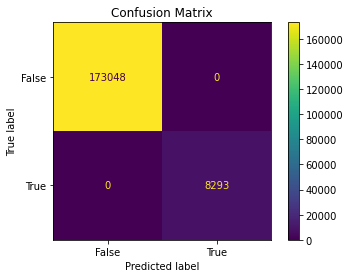

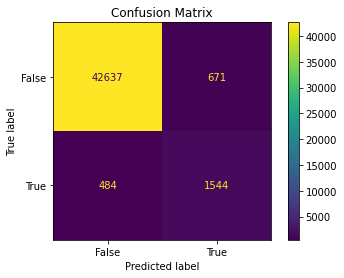

In [ ]:
#Decision Tree without resampling

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,Y_train)

Y_pred_train = clf.predict(X_train)
Y_pred_test = clf.predict(X_test)

#Evaluation to check accuracy

F1_DT = evaluationscore(Y_train, Y_test, Y_pred_train, Y_pred_test)
print()
confusion_matrix(Y_pred_train, Y_train)
print()
confusion_matrix(Y_pred_test, Y_test)

Train Accuracy: 1.0
Test Accuracy: 0.8573504480503754
Train F1-Score: 1.0
Test F1-Score: 0.8571428571428572



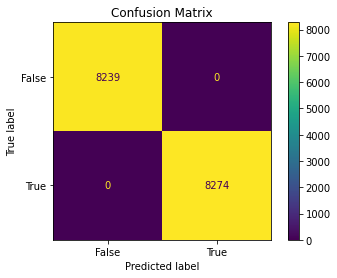

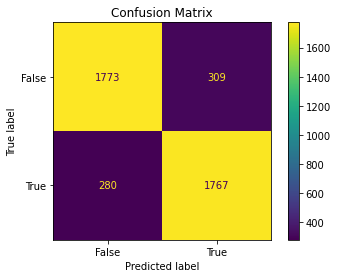

In [ ]:
#Decision Tree with undersampling

clf = DecisionTreeClassifier()
clf = clf.fit(X_train_u,Y_train_u)

Y_pred_train = clf.predict(X_train_u)
Y_pred_test = clf.predict(X_test_u)

#Evaluation to check accuracy
F1_DT_u = evaluationscore(Y_train_u, Y_test_u, Y_pred_train, Y_pred_test)
print()
confusion_matrix(Y_pred_train, Y_train_u)
print()
confusion_matrix(Y_pred_test, Y_test_u)

Train Accuracy: 1.0
Test Accuracy: 0.992315958540841
Train F1-Score: 1.0
Test F1-Score: 0.9923616774445503



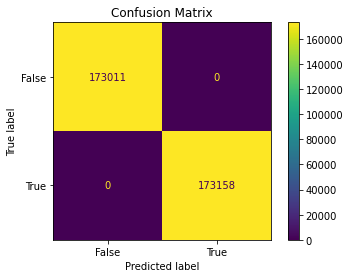

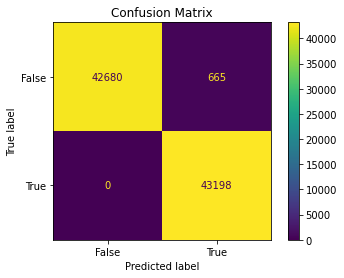

In [ ]:
#Decision tree with oversampling

clf = DecisionTreeClassifier()
clf = clf.fit(X_train_o,Y_train_o)

Y_pred_train = clf.predict(X_train_o)
Y_pred_test = clf.predict(X_test_o)

#Evaluation to check accuracy
F1_DT_o = evaluationscore(Y_train_o, Y_test_o, Y_pred_train, Y_pred_test)
print()
confusion_matrix(Y_pred_train, Y_train_o)
print()
confusion_matrix(Y_pred_test, Y_test_o)

## Random Forest

Train Accuracy: 0.9999779421090652
Test Accuracy: 0.9879124757367214
Train F1-Score: 0.9997587745748402
Test F1-Score: 0.8477777777777776



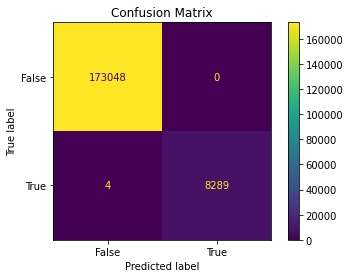

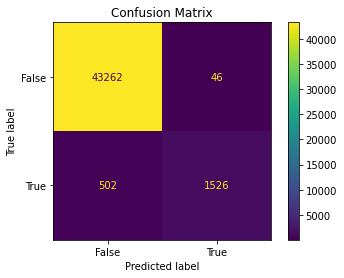

In [ ]:
#Random Forest without resampling
clf = RandomForestClassifier()
clf = clf.fit(X_train,Y_train.values.ravel())

Y_pred_train = clf.predict(X_train)
Y_pred_test = clf.predict(X_test)

#Evaluation for accuracy
F1_RF = evaluationscore(Y_train, Y_test, Y_pred_train, Y_pred_test)
print()
confusion_matrix(Y_pred_train, Y_train)
print()
confusion_matrix(Y_pred_test, Y_test)

Train Accuracy: 1.0
Test Accuracy: 0.8985226447081618
Train F1-Score: 1.0
Test F1-Score: 0.8955893346623474



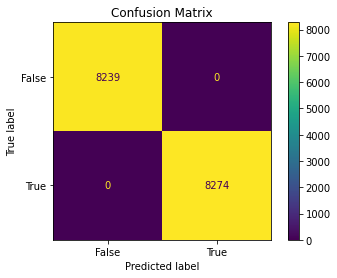

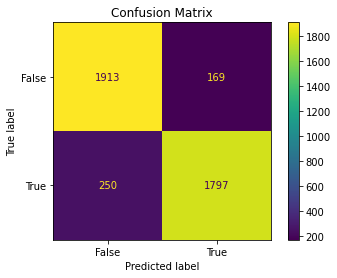

In [ ]:
#Random Forest Tree with undersampling
#Model
clf = RandomForestClassifier()
clf = clf.fit(X_train_u,Y_train_u.values.ravel())

#Predict
Y_pred_train = clf.predict(X_train_u)
Y_pred_test = clf.predict(X_test_u)

#Evaluation for better accuracy
F1_RF_u = evaluationscore(Y_train_u, Y_test_u, Y_pred_train, Y_pred_test)
print()
confusion_matrix(Y_pred_train, Y_train_u)
print()
confusion_matrix(Y_pred_test, Y_test_u)

Train Accuracy: 1.0
Test Accuracy: 0.9990987139341136
Train F1-Score: 1.0
Test F1-Score: 0.9990979947729953



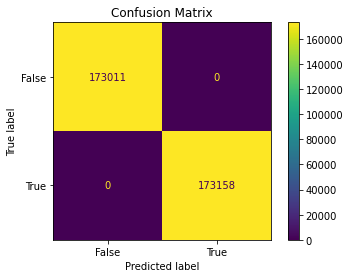

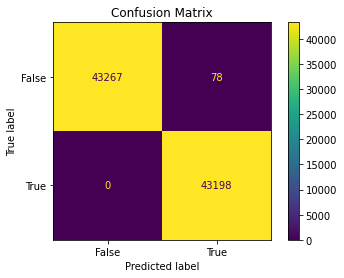

In [ ]:
#Random forest without oversampling

clf = RandomForestClassifier()
clf = clf.fit(X_train_o,Y_train_o.values.ravel())

Y_pred_train = clf.predict(X_train_o)
Y_pred_test = clf.predict(X_test_o)

F1_RF_o = evaluationscore(Y_train_o, Y_test_o, Y_pred_train, Y_pred_test)
print()
confusion_matrix(Y_pred_train, Y_train_o)
print()
confusion_matrix(Y_pred_test, Y_test_o)

# Compare for best model

In [ ]:
a = ['Decision Tree', 'Random Forest']; b = ['Without Resampling', 'Undersampling', 'Oversampling']
c = [F1_DT[1], F1_DT_u[1], F1_DT_o[1], F1_RF[1], F1_RF_u[1], F1_RF_o[1]]
c = [ '%.4f' % elem for elem in c ]


Compare = pd.DataFrame(list(product(a, b)), columns=['Model', 'Resampling Method'])
Compare['F1-Score Test'] = c
print(tabulate(Compare, headers = 'keys', tablefmt = 'fancy_grid'))

╒════╤═══════════════╤═════════════════════╤═════════════════╕
│    │ Model         │ Resampling Method   │   F1-Score Test │
╞════╪═══════════════╪═════════════════════╪═════════════════╡
│  0 │ Decision Tree │ Without Resampling  │          0.7278 │
├────┼───────────────┼─────────────────────┼─────────────────┤
│  1 │ Decision Tree │ Undersampling       │          0.8571 │
├────┼───────────────┼─────────────────────┼─────────────────┤
│  2 │ Decision Tree │ Oversampling        │          0.9924 │
├────┼───────────────┼─────────────────────┼─────────────────┤
│  3 │ Random Forest │ Without Resampling  │          0.8478 │
├────┼───────────────┼─────────────────────┼─────────────────┤
│  4 │ Random Forest │ Undersampling       │          0.8956 │
├────┼───────────────┼─────────────────────┼─────────────────┤
│  5 │ Random Forest │ Oversampling        │          0.9991 │
╘════╧═══════════════╧═════════════════════╧═════════════════╛


# 7. Evaluation Model

In [ ]:
#Random Forest Model without oversampling
#Model
clf_best = RandomForestClassifier()
clf_best = clf_best.fit(X_train_o,Y_train_o.values.ravel())

#Predict the Real Data (without oversampling)
Y_pred_train = clf_best.predict(X_train)
Y_pred_test = clf_best.predict(X_test)

In [ ]:
#Evaluation
c(Y_train, Y_test, Y_pred_train, Y_pred_test)
print()
print('Confusion Matrix for Random Forest in Train Data')
confusion_matrix(Y_pred_train, Y_train)
print()
print('Confusion Matrix for Random Forest in Test Data')
confusion_matrix(Y_pred_test, Y_test)
print()

TypeError: ignored

In [ ]:
#Variable Importance
importance = pd.Series(clf_best.feature_importances_, index=X_train.columns)
ax = importance.nlargest(5).plot(kind='barh', figsize=(8, 8)); ax.invert_yaxis()
plt.title('Most Important Variable')
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.show()